## Set up

In [1]:
import pickle
from copy import deepcopy
import pandas as pd
import numpy as np
from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter, median_filter
#visualization
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
#import custom functions
from custom_functions import *

### Load demo data

In [6]:
def process_data(path_csv, path_raws, nrcan_name = 'land_cover.tif', index = [0, 3], target_edge = False,
                 target_outlier = False, gaussian = False, clustering = False, calculate_layers = False):
    if path_csv is not None:
        #get y from csv and reshape
        raw = pd.read_csv(path_csv)
        raw.land_cover = raw.land_cover.astype('int')
        y_demo = raw['land_cover']
        #reshape to use y_demo with gaussian X
        y_demo = y_demo.values.reshape(2500, 2100).T
        y_demo = y_demo.flatten()
        
         #get X from gdal function
        raw = gdal_to_dataframe(path_raws, nrcan_name = nrcan_name, index = index, calculate_edge = target_edge)
        X_demo = raw.drop('y', axis = 1)
    else:
        #get X from gdal function
        raw = gdal_to_dataframe(path_raws, nrcan_name = nrcan_name, index = index, calculate_edge = target_edge)
        y_demo = raw.y
        X_demo = raw.drop('y', axis = 1)
    
    
    #X_demo = X_demo[['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11','B12', 'B8A']]

    if target_outlier is not False:
        if target_outlier[0] == 'B':
            X_demo[target_outlier] = outlier_fix(X_demo)[target_outlier]
        else:
            X_demo = outlier_fix(X_demo)
    
    if gaussian == True:
        #reset demo raw for matching filtering
        raw = gdal_to_dataframe(path_raws, nrcan_name = nrcan_name, index = index)
        #demo_raw = outlier_fix(demo_raw)
        #filter raws from path
        gauss_demo = filter_raws(path_raws, nrcan_name = nrcan_name, index = index)

        #concat gauss and raw
        gauss_demo_reset = gauss_demo.drop('y', axis = 1)
        #rename gauss columns
        gauss_names = [f'{name}g' for name in gauss_demo_reset.columns]
        gauss_demo_reset.columns = gauss_names
        #reset indices
        raw.reset_index(inplace=True, drop=True)
        gauss_demo_reset.reset_index(inplace=True, drop=True)    
        merged_df = pd.concat([raw, gauss_demo_reset], axis = 1)

        #select X values from gaussian dataframe
        X_demo = merged_df.drop('y', axis = 1)

        #X_demo = X_demo[['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11',
       #'B12', 'B8A', 'B01g', 'B02g', 'B03g', 'B04g', 'B05g', 'B06g', 'B07g', 'B08g', 'B09g', 'B11g', 'B12g', 'B8Ag']]
        
    if clustering is not False:
        param = pickle.load(open(clustering, 'rb'))
        demo_cluster = param.predict(X_demo.astype('double'))
        X_demo['clusters'] = demo_cluster
        
    if calculate_layers is not False:
        X_demo = add_layers(X_demo)
        X_demo = replace_values(X_demo)
        
        if calculate_layers == 'Extra':
            X_demo = add_extra_layers(X_demo)
        
    return X_demo, y_demo
    
    
X_test, y_test = process_data('../data_tests/demo_site.csv', '../data_tests/demo/raws', calculate_layers = 'Extra') 
X_test.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11',
       'B12', 'B8A', 'NDVI', 'Moisture', 'NDWI', 'NDSI', 'NIRB', 'ARG',
       'yellow', 'MIVI', 'GDVI'],
      dtype='object')

## Combine Forests with different features

Versions:
- 10_bin14_13: base of version 10 with add on forest_bin14 for class 14 and taking 15 and 17 from version 13 in that order
    - demo accuracy 52.40 (b: 41.22%)
- 10_xgbin14_13: base of version 10 with add on xgb_bin14 for class 14 and taking 15 and 17 from version 13 in that order
    - demo accuracy 52.45 (b: 41.35%)
- 14_xgbin14_13: base of version 14 with add on xg_bin14 for class 14 and taking 15 from version 13 in that order
    - demo accuracy 55.92 (b: 43.04)
    - trois accuracy 57.00 (b: 41.27)
    - calgary accuracy 42.49 (b: 25.05)
    
    
Processing:
- version 10: target_outlier = 'B01f', calculate_layers = True, nrcan_name = nrcan_name
- version 13: gaussian = True, clustering = '../models/kcluster_13.sav', calculate_layers = True,
- bin14: calculate_layers = 'Extra', nrcan_name = nrcan_name

In [5]:
#load in models
forest_14 = pickle.load(open('../models/forest14.sav', 'rb'))
forest_13 = pickle.load(open('../models/forest_13.sav', 'rb'))
xgb_bin14 = pickle.load(open('../models/xgb_bin14.sav', 'rb'))

In [42]:
process_dict = {'index' : [0, 3],
                'target_edge': None,
                'target_outlier' : False,
                'gaussian' : False,
                'clustering' : False,
                'calculate_layers' : False}
binary_dict = {'model': None, 'class': None}

def predict_combo(models, path_csv, path_raws, index = [0, 3], process_dict = process_dict, binary = binary_dict, class_lists = [[14], [15]], nrcan_name = 'land_cover.tif'):
    
    pred_list = []
    
    
    
    for i in range(len(models)):
        test_X, test_y = process_data(path_csv, path_raws, index = index, 
                                      target_edge = process_dict['target_edge'][i],
                                      target_outlier = process_dict['target_outlier'][i],
                                      gaussian = process_dict['gaussian'][i],
                                      clustering = process_dict['clustering'][i],
                                      calculate_layers = process_dict['calculate_layers'][i], nrcan_name = nrcan_name)
        pred = pd.DataFrame(models[i].predict(test_X))
        pred_list.append(pred)
        
        if i in binary['model']:
               for j in range(len(binary['class'])):
                    pred_list[i] = pred_list[i].replace(1, binary['class'][j])
    
    #take first model as base model
    base_pred = pred_list[0]
    
    #select only classes in list from additional forest
    for i in range(len(class_lists)):
        subset = pred_list[i + 1][pred_list[i + 1].isin(class_lists[i]) ]
        #updat base_pred with subset
        base_pred.update(subset)
        #convert to int
        base_pred = base_pred.astype('int')
    
    return base_pred, test_y


### Demo test

In [43]:
process_10_bin14_13 = {
                       'target_edge': ['B8A', None, None],
                        'target_outlier' : ['B01f', False, False],
                        'gaussian' : [False, False, True],
                        'clustering' : [False, False, '../models/kcluster_13.sav'],
                        'calculate_layers' : [True, 'Extra', True]}
binary_10_bin14_13 = {'model': [1], 'class': [14]}

combo_pred, y_true = predict_combo([forest_14, xgb_bin14, forest_13], '../data_tests/demo_site.csv',  '../data_tests/demo/raws',
                                  process_dict = process_10_bin14_13, binary = binary_10_bin14_13)

getting edge


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, balanced_accuracy_score

C:\Users\fynn\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.4304164166456214
0.5591626666666667


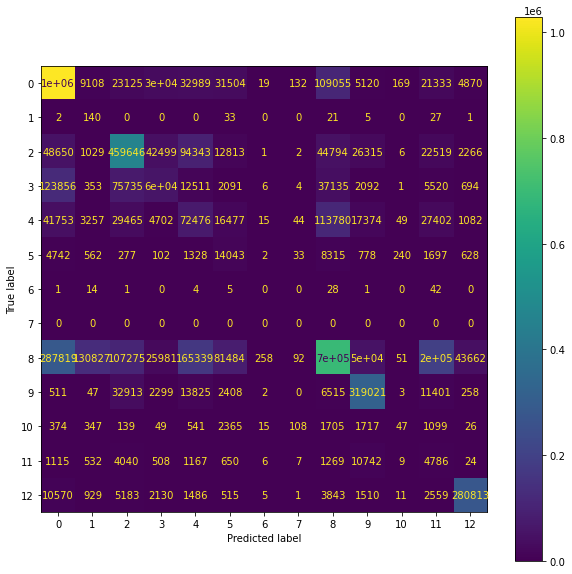

In [14]:
#accuracy
print(balanced_accuracy_score(y_true, combo_pred))
print(accuracy_score(y_true, combo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_test, combo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

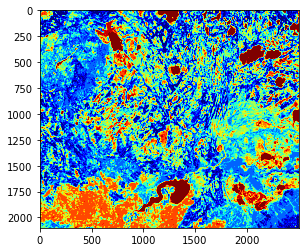

In [15]:
map_pred = np.asarray(combo_pred.values).reshape(2100, 2500)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [16]:
#OPTIONAL: save matrix and map as versions
#save confusion matrix
cm_forest_fig.figure_.savefig(os.path.join('evaluation', 'demo/combo', '14_xgbin14_13_cm.png'))

#save prediction map
prediction_map.figure.savefig(os.path.join('evaluation', 'demo/combo', '14_xgbin14_13_map.png'))

In [17]:
print(classification_report(y_true, combo_pred, zero_division = 1))

              precision    recall  f1-score   support

           1       0.66      0.79      0.72   1295963
           2       0.00      0.61      0.00       229
           5       0.62      0.61      0.62    754883
           6       0.35      0.19      0.24    319587
           8       0.18      0.22      0.20    327876
          10       0.09      0.43      0.14     32747
          12       0.00      0.00      0.00        96
          13       0.00      1.00      0.00         0
          14       0.68      0.39      0.50   1786474
          15       0.73      0.82      0.77    389203
          16       0.08      0.01      0.01      8532
          17       0.02      0.19      0.03     24855
          18       0.84      0.91      0.87    309555

    accuracy                           0.56   5250000
   macro avg       0.33      0.47      0.32   5250000
weighted avg       0.62      0.56      0.57   5250000



### Random extent test

In [37]:
#X_ran, y_ran = process_data(None, '../data_tests/trois/raws', nrcan_name = 'NRCAN_transformed.tif', index = [-14, -11], gaussian = True, clustering = 'models/kcluster_13.sav', calculate_layers = True)
X_ran, y_ran = process_data(None, '../data_tests/calgary/raws', nrcan_name = 'NRCAN_transformed.tif', index = [-14, -11], target_edge = 'B8A', target_outlier = 'B01f', calculate_layers = True)

getting edge


In [ ]:
map_pred = np.asarray(y_ran.values).reshape(656, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

#### Combination

In [44]:
combo_pred, y_true = predict_combo([forest_14, xgb_bin14, forest_13], None, '../data_tests/calgary/raws', index = [-14, -11], 
                                   process_dict = process_10_bin14_13, binary = binary_10_bin14_13, nrcan_name = 'NRCAN_transformed.tif')

getting edge


0.2497366021227513
0.42879308855291576


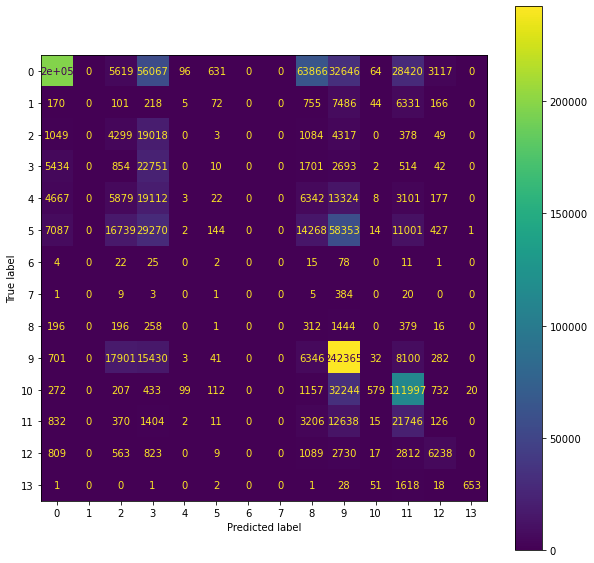

In [45]:
#accuracy
print(balanced_accuracy_score(y_true, combo_pred))
print(accuracy_score(y_true, combo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_true, combo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

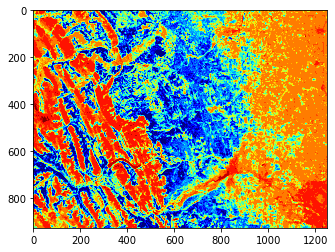

In [46]:
map_pred = np.asarray(combo_pred.values).reshape(926, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

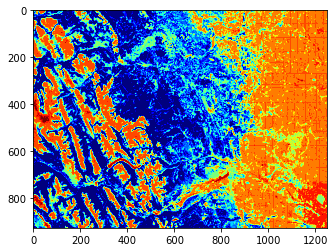

In [32]:
map_pred = np.asarray(y_true).reshape(926, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [47]:
print(classification_report(y_true, combo_pred, zero_division = 1))

              precision    recall  f1-score   support

           1       0.90      0.51      0.65    387764
           2       1.00      0.00      0.00     15348
           5       0.08      0.14      0.10     30197
           6       0.14      0.67      0.23     34001
           8       0.01      0.00      0.00     52635
          10       0.14      0.00      0.00    137306
          11       1.00      0.00      0.00       158
          12       1.00      0.00      0.00       423
          14       0.00      0.11      0.01      2802
          15       0.59      0.83      0.69    291201
          16       0.70      0.00      0.01    147852
          17       0.11      0.54      0.18     40350
          18       0.55      0.41      0.47     15090
          19       0.97      0.28      0.43      2373

    accuracy                           0.43   1157500
   macro avg       0.51      0.25      0.20   1157500
weighted avg       0.59      0.43      0.42   1157500



#### Forest only

In [38]:
forest_pred = forest_14.predict(X_ran)

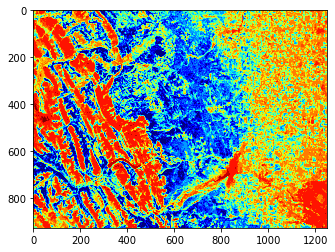

In [39]:
map_pred = np.asarray(forest_pred).reshape(926, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [41]:
print(balanced_accuracy_score(y_ran, forest_pred))
print(accuracy_score(y_ran, forest_pred))

#confusion matrix
cm_forest = confusion_matrix(y_true, forest_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest_10.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

0.2416400789278137
0.39359568034557235


NameError: name 'forest_10' is not defined

In [ ]:
print(classification_report(y_true, combo_pred, zero_division = 1))

In [ ]:
print(classification_report(y_true, forest_pred, zero_division = 1))

## Combine seperate models

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier